In [160]:
import pandas as pd
import numpy as np
import re
import datetime
import math
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
import geopandas as gpd
import h3 # h3 bins from uber
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, minmax_scale
import scipy.cluster.hierarchy as sch
import holidays
#pd.set_option('display.max_rows', None)


In [418]:
def create_crash_df(train_file = '../Inputs/Train.csv'):  
    '''
    loads crash data from input folder into dataframe
    '''
    crash_df = pd.read_csv(train_file, parse_dates=['datetime'])
    return crash_df
    
def create_temporal_features(df, date_column='datetime'):
    '''
    Add the set of temporal features the the df based on the datetime column. Returns the dataframe.
    '''
    dict_windows = {1: "00-03", 2: "03-06", 3: "06-09", 4: "09-12", 5: "12-15", 
                    6: "15-18", 7: "18-21", 8: "21-24"}
    dict_months = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                   7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
    rainy_season = ["Mar", "Apr", "May", "Oct", "Nov", "Dec"]
    df["time"] = df[date_column].apply(lambda x: x.time())
    df["time_window"] = df[date_column].apply(lambda x: math.floor(x.hour / 3) + 1)
    df["time_window_str"] = df["time_window"].apply(lambda x: dict_windows.get(x))
    df["day"] = df[date_column].apply(lambda x: x.day)
    df["weekday"] = df[date_column].apply(lambda x: x.weekday())
    df["month"] = df[date_column].apply(lambda x: dict_months.get(x.month))
    df["half_year"] = df[date_column].apply(lambda x: 1 if x.month<7 else 2)
    df["rainy_season"] = df["month"].apply(lambda x: 1 if (x in rainy_season) else 0)
    df["year"] = df[date_column].apply(lambda x: x.year)
    df["date_trunc"] = df[date_column].apply(lambda x: x.date()) #this does something strange that breaks the code if higher
    df["holiday"] = df["date_trunc"].apply(lambda x: 1 if (x in holidays.Kenya()) else 0)
    return df

def drop_temporal(df):
    '''
    helper function to remove all the granular temporal columns once they have been used for generating other columns for joining.
    '''
    df = df.drop(["day", "time_window", "time_window_str", "time_window_str", "month", "year", "weekday", "rainy_season", "date_trunc", "time", "half_year", "holiday"], axis=1)
    return df


def assign_hex_bin(df,lat_column="latitude",lon_column="longitude"):
    '''
    Takes lat,lon and creates column with h3 bin name for three levels of granualirity.
    '''
    df["h3_zone_5"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 5),axis=1)
    df["h3_zone_6"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 6),axis=1)
    df["h3_zone_7"] = df.apply(lambda x: h3.geo_to_h3(x[lat_column], x[lon_column], 7),axis=1)
    return df

def plot_centroids(crash_data_df, centroids, cluster='cluster'):
    '''
    plots the crash data points from crash_data_df and overlays the ambulance location from centroids. 
    Can be used in a loop by giving 'cluster' value as a parameter to label the chart with the cluster name.
    '''
    
    fig, axs = plt.subplots(figsize=(8, 5))
    plt.scatter(x = crash_data_df['longitude'], y=crash_data_df['latitude'], s=1, label='Crash locations' )
    plt.scatter(x = centroids[:,1], y=centroids[:,0], marker="x",
                color='r',label='Ambulances locations',s=100)
    axs.set_title('Scatter plot : Ambulaces locations vs Crash locations :'+cluster)
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.legend()
    plt.show()

def plot_k_means(crash_df_with_cluster):
    '''
    Runs mulitple k-means clustering on the crash_df based on the split of tw clusters in the 'cluster' column.
    Feeds the crash data points and the resulting centroids for that cluster into the plot centroids function.
    return once chart for each cluster.
    '''
    for i in crash_df_with_cluster.cluster.unique():
        kmeans = KMeans(n_clusters=6, verbose=0, tol=1e-3, max_iter=100, n_init=20, copy_x= True)
        kmeans.fit(crash_df_with_cluster.query('cluster==@i')[['latitude','longitude']])
        centroids = kmeans.cluster_centers_
        plot_centroids(crash_df_with_cluster.query('cluster==@i'), centroids=centroids, cluster=i) 
        
def plot_dendrogram(df):
    '''Use Dendrogram to determine an optimal number of clusters'''
    plt.figure(figsize=(45,18))
    plt.title('Androgram')
    plt.xlabel('time_buckets_days')
    plt.ylabel('Euclidean distances')
    dendrogram = sch.dendrogram(sch.linkage(df, method = 'ward'))
    plt.show()

def calculate_TW_cluster(crash_df, method='MeanShift', verbose=0):
    '''
    Takes crash dataframe with temporal features added as input
    Function to perform clustering of time windows and assign labels back to crash dataframe. 
    Output is dataframe with additional column for labels
    If verbosity is increased, information about the clusters to printed.
    '''
    group_stats = crash_df.groupby(['time_window_str', 'weekday'])
    group_stats = group_stats.agg({'latitude': [np.mean, np.std],'longitude': [np.mean, np.std, 'count']})
    # flatten out groupby object and name columns again
    group_stats = group_stats.reset_index()
    group_stats.columns = group_stats.columns.get_level_values(0)
    group_stats.columns.values[[2,3,4,5,6]] = ['latitude_mean', 'latitude_std',
                                               'longitude_mean', 'longitude_std', 'RTA_count']
    X = group_stats.loc[:,['RTA_count']]#, 'latitude_mean', 'latitude_std','longitude_mean', 'longitude_std']]
    scaler = StandardScaler()
    scale_columns = ['latitude_mean', 'latitude_std','longitude_mean', 'longitude_std']
    #X[scale_columns] = scaler.fit_transform(X[scale_columns])
    if verbose > 5:
        X1 = X.copy()
        X1['RTA_count'] = minmax_scale(X1['RTA_count'])
        plot_dendrogram(X1)
        
    if method == 'MeanShift':
        #X['RTA_count'] = minmax_scale(X['RTA_count'])
        ms_model = MeanShift().fit(X)
        labels = ms_model.labels_

    elif method == 'GMM':
        X['RTA_count'] = minmax_scale(X['RTA_count'])
        gmm = GaussianMixture(n_components=4, verbose=verbose, random_state=42)
        gmm.fit(X)
        labels = gmm.predict(X)
    else:
        display('Select method "MeanShift" or "GMM"')
        #return 'error'

    labels = pd.DataFrame(labels,columns=['cluster'])
    clustered_time_buckets = pd.concat([group_stats,labels], axis=1)

    if verbose > 0:
        display(clustered_time_buckets.groupby('cluster').agg({'RTA_count': ['count', np.sum]}))
    if verbose > 1:
        plot_TW_cluster(clustered_time_buckets)
    
    crash_df = crash_df.merge(clustered_time_buckets[['time_window_str', 'weekday','cluster']], how='left', on=['time_window_str', 'weekday'])
    return crash_df

def plot_TW_cluster(clustered_time_buckets):
    '''
    Displays stripplot to show how different times of the week are assigned to TW clusters.
    '''
    tb_clusters = sns.FacetGrid(clustered_time_buckets,hue='cluster', height=5)
    tb_clusters.map(sns.stripplot,'weekday', 'time_window_str', s=25, order = ['00-03', '03-06', '06-09', '09-12', 
                                                                              '12-15', '15-18', '18-21', '21-24'])
    
def assign_TW_cluster(weekday, time_window, holiday=0, strategy='baseline'):
    '''
    Can be used in a lambda function to return the time window cluster for a given day and time window.
    e.g. crash_df["cluster"] = crash_df.apply(lambda x: return_TW_cluster(x.weekday, x.time_window_str) ,axis=1)
    This is called by the function: create_cluster_feature.
    '''
    if strategy == 'baseline':
        return 'baseline'
    
    if strategy == 'mean_shift_modified':
        if holiday == 1:
            return 'off_peak'        
        elif weekday == 6:
            return 'off_peak'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'peak'
    
    elif strategy == 'saturday_2':
        if holiday == 1:
            return 'off_peak'        
        elif weekday == 6:
            return 'off_peak'
        elif weekday in [0,1,2,3,4]:
            if time_window in ["06-09"]:
                return 'peak'
            elif time_window in ["09-12", "12-15", "15-18", "18-21"]:
                return 'middle'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'    
        elif weekday == 5:
            if time_window in ["06-09", "12-15", "15-18", "18-21"]:
                return 'saturday_busy'
            elif time_window in ["00-03", "03-06", "21-24"]:
                return 'off_peak'
            elif time_window in ["09-12"]:
                return 'saturday_busy'      
    
    elif strategy == 'no_cluster':
        return (str(weekday)+str(time_window)+str(holiday))
            
def create_cluster_feature(crash_df, strategy='baseline', verbose=0):
    '''
    Function takes crash df and creates new column with tw cluster labels.
    If verbose is increased, the time window clusters will be visualised.
    '''
    crash_df["cluster"] = crash_df.apply(lambda x: 
                                         assign_TW_cluster(weekday=x.weekday,
                                                           time_window=x.time_window_str,
                                                           strategy=strategy) 
                                         ,axis=1)
    
    print(f'{crash_df.cluster.nunique()} clusters created')
    if verbose > 1:
        tb_clusters = sns.FacetGrid(crash_df,hue='cluster', height=5)
        tb_clusters.map(sns.stripplot,'weekday', 'time_window_str', s=20, 
                                       order = ['00-03', '03-06', '06-09', '09-12', 
                                                '12-15', '15-18', '18-21', '21-24'],
                                    label = 'Time Window Clusters')
    return crash_df
            

def create_baseline_submission_df(crash_data_df, date_start='2019-07-01', date_end='2020-01-01', method='k_means'):
    '''Takes crash data and creates a data frame in the format needed for submission'''
       
    # star grid
    if method == 'star':
        lat_centroid = list(crash_data_df.latitude.quantile(q=[1/5,2/5,3/5,4/5]))
        lon_centroid = list(crash_data_df.longitude.quantile(q=[1/4,2/4,3/4]))
        centroids=[(lat_centroid[1],lon_centroid[0]),(lat_centroid[2],lon_centroid[0]),
                   (lat_centroid[0],lon_centroid[1]),(lat_centroid[3],lon_centroid[1]),
                   (lat_centroid[1],lon_centroid[2]),(lat_centroid[2],lon_centroid[2])]
    
    # Create centroids via k-means
    if method == 'k_means':
        kmeans = KMeans(n_clusters=6, verbose=0, tol=1e-3, max_iter=100, n_init=20, copy_x= True)
        kmeans.fit(crash_data_df[['latitude','longitude']])
        centroids = kmeans.cluster_centers_
    
    # Create Date range covering submission period set
    dates = pd.date_range(date_start, date_end, freq='3h')
        
    # Create submission dataframe
    submission_df = pd.DataFrame({'date':dates})
    for ambulance in range(6):
        # Place an ambulance in the center of the city:
        submission_df['A'+str(ambulance)+'_Latitude'] = centroids[ambulance][0]
        submission_df['A'+str(ambulance)+'_Longitude'] = centroids[ambulance][1]
    return submission_df, centroids

def create_k_means_centroids(crash_df_with_cluster, verbose=0):
    centroids_dict = {}
    for i in crash_df_with_cluster.cluster.unique():
        kmeans = KMeans(n_clusters=6, verbose=0, tol=1e-4, max_iter=200, n_init=20)
        kmeans.fit(crash_df_with_cluster.query('cluster==@i')[['latitude','longitude']])
        centroids = kmeans.cluster_centers_
        centroids_dict[i] = centroids.flatten()
        if verbose > 2:
            plot_centroids(crash_df_with_cluster.query('cluster==@i'), centroids, cluster=i)
        if verbose > 5:
            print(centroids)
    print(f'{len(centroids_dict)} centroids created')
    return centroids_dict
        
def centroid_to_submission(centroids_dict, date_start='2019-07-01', date_end='2020-01-01', tw_cluster_strategy='baseline'):
    '''Takes dictionary of clusters and centroids and creates a data frame in the format needed for submission'''

    # Create Date range covering submission period set
    dates = pd.date_range(date_start, date_end, freq='3h')
    submission_df = pd.DataFrame({'date':dates})
    submission_df = create_temporal_features(submission_df,'date')
    submission_df["cluster"] = submission_df.apply(lambda x: assign_TW_cluster(x.weekday, x.time_window_str, strategy=tw_cluster_strategy) ,axis=1)
    ambulance_columns = ['A0_Latitude', 'A0_Longitude', 'A1_Latitude','A1_Longitude', 'A2_Latitude', 'A2_Longitude', 
                         'A3_Latitude', 'A3_Longitude', 'A4_Latitude', 'A4_Longitude', 'A5_Latitude', 'A5_Longitude']
    for i in submission_df["cluster"].unique():
        submission_df["placements"] = submission_df["cluster"].apply(lambda x: centroids_dict.get(x))
        submission_df[ambulance_columns] = pd.DataFrame(submission_df.placements.tolist(), index=submission_df.index)
    submission_df = submission_df.drop('placements', axis=1)
    submission_df = drop_temporal(submission_df)
    submission_df = submission_df.drop(["cluster"], axis=1)
    print('submission dataframe created')
    return submission_df

def create_submission_csv(submission_df, crash_source, tw_cluster_strategy, model_name, path='../Outputs/'):
    '''Takes dataframe in submission format and outputs a csv file with matching name'''
    current_time = datetime.datetime.now()
    filename = f'{current_time.year}{current_time.month}{current_time.day}_{crash_source}_{tw_cluster_strategy}_{model_name}.csv'
    submission_df.to_csv(path+filename,index=False)
    print(f'{filename} saved in {path}') 
    
    
def score(train_placements_df, crash_df, test_start_date='2018-01-01', test_end_date='2019-12-31'):
          
    '''
    Can be used to score the ambulance placements against a set of crashes. Can be used on all crash data, train_df or holdout_df as crash_df.
    '''
    test_df = crash_df.loc[(crash_df.datetime > test_start_date) & (crash_df.datetime < test_end_date)]
    print(f'Data points in test period: {test_df.shape[0]}' )
    total_distance = 0
    for crash_date, c_lat, c_lon in test_df[['datetime', 'latitude', 'longitude']].values:
        row = train_placements_df.loc[train_placements_df.date < crash_date].tail(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

def split_accident_df(data, strategy, test_size=0.3, random_state=42):
    '''
    Splits the data set into a train and a test set.
    strategy:
        random = splits off random indices, using test_size and random_state parameters
        year_2019 = splits the days of 2019 off into a test set
        percentage_month = splits off the last days of every month to the test set according to the test_size
        2nd_half_2018 = oversamples the months from July to December 2018 by about 33%
    '''
    if strategy == "random":
        data = data.sample(frac=1, random_state=random_state).reset_index().drop("index", axis=1)
        split_at = round(data.shape[0] * test_size)
        data_train = data.iloc[split_at:, :]
        data_test = data.iloc[:split_at, :]
    elif strategy == "year_2019":
        data_train = data[data["datetime"] < "2019-01-01"]
        data_test = data[data["datetime"] >= "2019-01-01"]
    elif strategy == "percentage_month":
        split_at = round(30 * (1-test_size))
        data_train = data.loc[data["day"] <= split_at]
        data_test = data.loc[data["day"] > split_at]
    elif strategy == "2nd_half_2018":
        train_samples = round(data.shape[0] * (1-test_size))
        test_samples = round(data.shape[0] * test_size)
        data_train = data.sample(n=train_samples, weights="half_year", random_state=random_state)
        data_test = data.sample(n=test_samples, weights="half_year", random_state=random_state)
        
    return data_train, data_test


4 clusters created


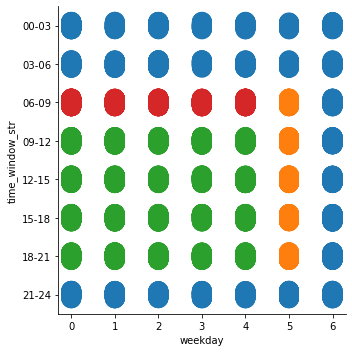

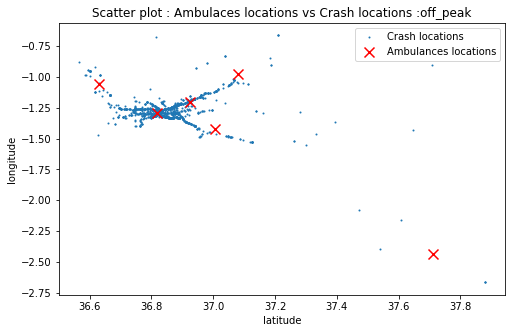

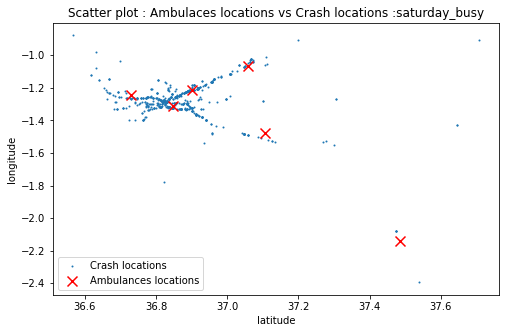

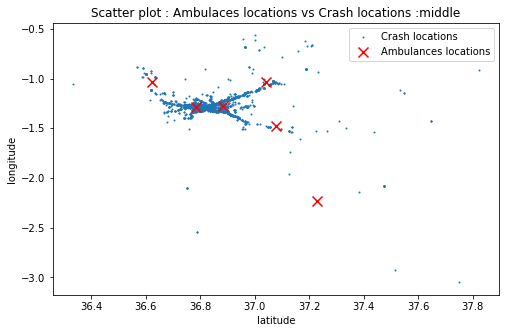

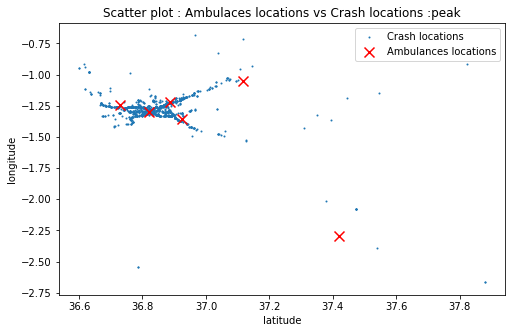

4 centroids created
submission dataframe created
Total size of test set: 0
Data points in test period: 0
Total size of train set: 6318
Data points in test period: 6318
Score on test set: 0.0
Score on train set: 0.05841445729122752 (avg distance per accident)
submission dataframe created
2020123_Train_saturday_2_k_means.csv saved in ../Outputs/


In [419]:
def ambulance_placement_pipeline(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                                 holdout_strategy='year_2019', holdout_test_size=0.3,
                                 test_period_date_start='2019-01-01', test_period_date_end='2019-07-01',
                                 tw_cluster_strategy='saturday_2', placement_model='k_means', verbose=0):  
    '''
    load crash data (from train or prediction) and apply feautre engineering, run tw clustering (based on strategy choice) 
    create ambulance placements, create output file.
    '''
    crash_df = create_crash_df(train_file = input_path+crash_source_csv+'.csv')
    crash_df = create_temporal_features(crash_df)
    crash_df, test_df = split_accident_data(data=crash_df, strategy=holdout_strategy, test_size=holdout_test_size)
    test_df = drop_temporal(test_df)
    crash_df = create_cluster_feature(crash_df, strategy=tw_cluster_strategy, verbose=verbose)
    centroids_dict = create_k_means_centroids(crash_df, verbose=verbose)
    train_placements_df = centroid_to_submission(centroids_dict, date_start='2018-01-01', date_end='2019-12-31', tw_cluster_strategy=tw_cluster_strategy)
    print(f'Total size of test set: {test_df.shape[0]}')
    test_score = score(train_placements_df, test_df, test_start_date=test_period_date_start, test_end_date=test_period_date_end)
    print(f'Total size of train set: {crash_df.shape[0]}')
    train_score = score(train_placements_df,crash_df, test_start_date=test_period_date_start, test_end_date=test_period_date_end)
    print(f'Score on test set: {test_score / max(test_df.shape[0],1)}')
    print(f'Score on train set: {train_score / crash_df.shape[0] } (avg distance per accident)')

    
# create file for submitting to zindi
    submission_df = centroid_to_submission(centroids_dict, date_start='2019-07-01', date_end='2020-01-01', tw_cluster_strategy=tw_cluster_strategy)
    create_submission_csv(submission_df, crash_source=crash_source_csv, tw_cluster_strategy=tw_cluster_strategy, model_name=placement_model, path=output_path)
    
ambulance_placement_pipeline(input_path='../Inputs/', output_path='../Outputs/', crash_source_csv='Train',
                              holdout_strategy='random', holdout_test_size=0.00,
                              test_period_date_start='2018-01-01', test_period_date_end='2019-12-31',
                              tw_cluster_strategy='saturday_2', placement_model='k_means', verbose=5)